# **Quantium Virtual Internship - Retail Strategy and Analytics - Task 2**

# **Experimentation and uplift testing**
**Extend your analysis from Task 1 to help you identify benchmark stores that** **allow you to test the trial store layouts' impact on customer sales.**  

**Importation of necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp,ttest_ind,t

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Reading the data

In [3]:
data  =  pd.read_csv('/content/drive/MyDrive/data/QVI_data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


Adding a new month and year column

In [4]:
# converting to datetime type

data['DATE'] = pd.to_datetime(data['DATE'])
data['Year_Month'] = data['DATE'].dt.to_period('M')
data['Year_Month'].dtype

period[M]

**Filter to the pre-trial period and stores with full observation periods**

In [5]:
data.groupby(data['DATE'].dt.year)['Year_Month'].nunique()

DATE
2018    6
2019    6
Name: Year_Month, dtype: int64

In [ ]:
# Dropping incomplete stores

In [6]:
stores_df = data.groupby('STORE_NBR')['Year_Month'].nunique()
missing_tx_stores = stores_df[stores_df != 12].index.to_list()
print(f'Stores missing transactions in all months: {missing_tx_stores}')
print(f'Dataframe shape before dropping the undesired entries: {data.shape}')

Stores missing transactions in all months: [11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]
Dataframe shape before dropping the undesired entries: (264834, 13)


In [7]:
ind_to_drop = data[data['STORE_NBR'].isin(missing_tx_stores)].index
comp_df = data.drop(ind_to_drop)
print(f'Dataframe shape after dropping stores with incomplete entries: {comp_df.shape}')

Dataframe shape after dropping stores with incomplete entries: (264645, 13)


In [ ]:
# Filtering to before the trial period

In [8]:
pre_trial_df = comp_df[comp_df['Year_Month'] < '2019-02']
print(pre_trial_df.shape)

(155734, 13)


In [9]:
trial_df = comp_df[comp_df['Year_Month'] >= '2019-02']

In [10]:
trial_df['Year_Month'].unique()

<PeriodArray>
['2019-03', '2019-06', '2019-04', '2019-05', '2019-02']
Length: 5, dtype: period[M]

**Statistics for our analysis**

Next, we define the measure calculations to use during the analysis

In [11]:
# tot_sales per store per month

stats_df = pre_trial_df.groupby(['STORE_NBR','Year_Month'])[['TOT_SALES']].sum()

In [12]:
# no of customers

stats_df['monthly_uniq_cust'] = pre_trial_df.groupby(['STORE_NBR','Year_Month'])['LYLTY_CARD_NBR'].nunique()

In [13]:
# Transactions per customer

stats_df['txn_per_cust'] = pre_trial_df.groupby(['STORE_NBR','Year_Month'])['TXN_ID'].nunique()/pre_trial_df.groupby(['STORE_NBR','Year_Month'])['LYLTY_CARD_NBR'].nunique()

In [14]:
# chips per transaction

stats_df['chips_per_txn'] = pre_trial_df.groupby(['STORE_NBR','Year_Month'])['PROD_QTY'].sum()/pre_trial_df.groupby(['STORE_NBR','Year_Month'])['TXN_ID'].nunique()

In [15]:
# Average price per unit

stats_df['avg_price_per_unit'] = pre_trial_df.groupby(['STORE_NBR','Year_Month'])['TOT_SALES'].sum()/pre_trial_df.groupby(['STORE_NBR','Year_Month'])['PROD_QTY'].sum()

In [16]:
stats_df = stats_df.rename(columns={'TOT_SALES':'monthly_sales'})

**Correlation function**

In [17]:
def calc_correlation(store):

    scores = []
    metrics = stats_df[['monthly_sales','monthly_uniq_cust']]
    for i in metrics.index:
        scores.append(metrics.loc[store].corrwith(metrics.loc[i[0]]))
    corr_df = pd.DataFrame(scores)
    corr_df.index = metrics.index
    corr_df = corr_df.drop_duplicates()
    corr_df.index = [s[0] for s in corr_df.index]
    corr_df = corr_df.rename_axis('store_nbr', axis='index')
    corr_df = corr_df.drop(index=[store])
    corr_df = corr_df.abs()
    corr_df['mean_corr'] = (corr_df['monthly_sales'] + corr_df['monthly_uniq_cust'])/2
    corr_df = corr_df.sort_values(by='mean_corr',ascending=False)
    return corr_df

**Finding the control stores**

We'll select our control stores based on the correlation score and do a visual comparison as well.

**Our trial stores are stores 77,86,88.**

**STORE 77**

In [18]:
corr_df = calc_correlation(77)

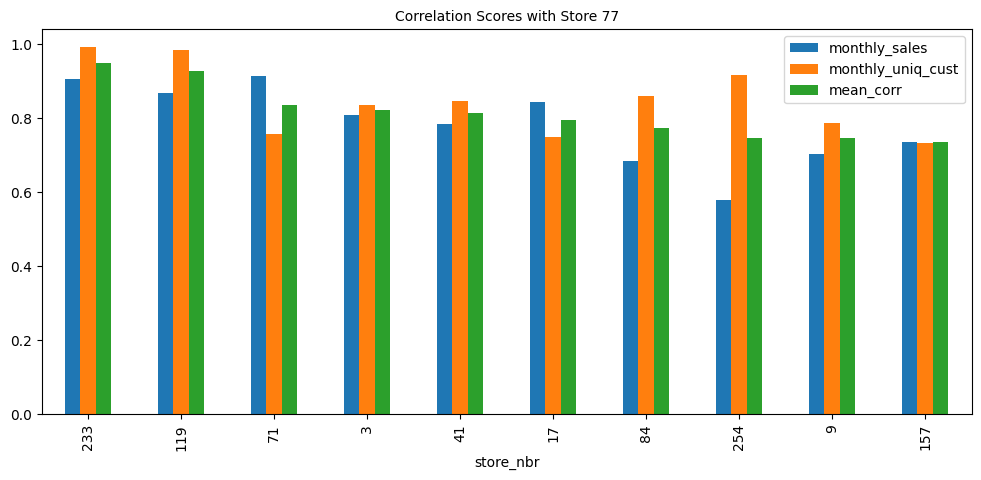

In [19]:
corr_df.head(10).plot(kind='bar',figsize=(12,5))
plt.title('Correlation Scores with Store 77',fontsize=10)
plt.show()

**Based on correlation scores, the most appropriate control store for Store 77 appears to be Store 233.**

**Total sales**

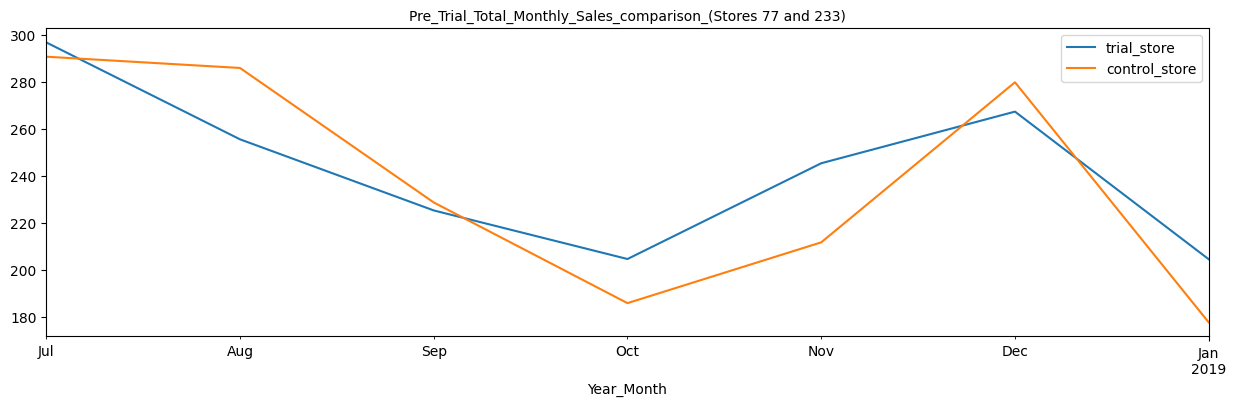

In [21]:
plt.figure(figsize=(15,4))
stats_df.loc[77]['monthly_sales'].plot(label='trial_store')
stats_df.loc[233]['monthly_sales'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_Sales_comparison_(Stores 77 and 233)',fontsize=10)
plt.legend()
plt.show()

**No. of customers**

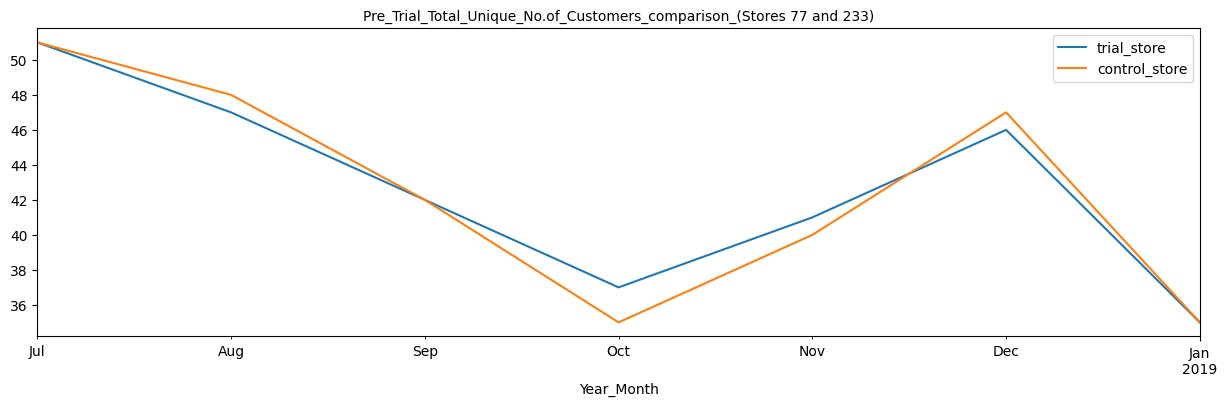

In [22]:
plt.figure(figsize=(15,4))
stats_df.loc[77]['monthly_uniq_cust'].plot(label='trial_store')
stats_df.loc[233]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Pre_Trial_Total_Unique_No.of_Customers_comparison_(Stores 77 and 233)',fontsize=10)
plt.legend()
plt.show()

**Assessment of the pre_trial and trial periods**

**Conducting a null hypothesis to confirm the difference**

In [28]:
metrics = ['monthly_sales','monthly_uniq_cust']

In [29]:
values = []
ttest_res = []
for i in metrics:
  values.append(ks_2samp(stats_df.loc[77][i],stats_df.loc[233][i]))
  ttest_res.append(ttest_ind(stats_df.loc[77][i],stats_df.loc[233][i]))
diff_df = pd.DataFrame(values,index = metrics)
diff_df2 = pd.DataFrame(ttest_res,index = metrics)

<ipython-input-29-b3503b00c020>:4: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  values.append(ks_2samp(stats_df.loc[77][i],stats_df.loc[233][i]))


In [32]:
# KS test results

values

[KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629, statistic_location=267.3, statistic_sign=1),
 KstestResult(statistic=0.14285714285714285, pvalue=0.9999609537692629, statistic_location=46, statistic_sign=1)]

In [33]:
# T-test results

ttest_res

[Ttest_indResult(statistic=0.2508625111443089, pvalue=0.8061643437868989),
 Ttest_indResult(statistic=0.044382389011481414, pvalue=0.9653295968758971)]

The statistic and p_values of both tests show there is not enough evidence to conclude that the two samples have different distributions in both the KS tests and T-tests.

In [30]:
diff_df

,statistic,pvalue
monthly_sales,0.285714,0.962704
monthly_uniq_cust,0.142857,0.999961


In [31]:
diff_df2

,statistic,pvalue
monthly_sales,0.250863,0.806164
monthly_uniq_cust,0.044382,0.965330


In [37]:
# the p-values are high,t_statistic quite low ,Hence we cannot reject reject the null hypothesis

**Contrasting with trial period**

In [23]:
# Calcuting the perfromance staistics for the trial period

trial_stats_df = trial_df.groupby(['STORE_NBR','Year_Month'])[['TOT_SALES']].sum()
trial_stats_df['monthly_uniq_cust'] = trial_df.groupby(['STORE_NBR','Year_Month'])['LYLTY_CARD_NBR'].nunique()
trial_stats_df['txn_per_cust'] = trial_df.groupby(['STORE_NBR','Year_Month'])['TXN_ID'].nunique()/trial_df.groupby(['STORE_NBR','Year_Month'])['LYLTY_CARD_NBR'].nunique()
trial_stats_df['chips_per_txn'] = trial_df.groupby(['STORE_NBR','Year_Month'])['PROD_QTY'].sum()/trial_df.groupby(['STORE_NBR','Year_Month'])['TXN_ID'].nunique()
trial_stats_df['avg_price_per_unit'] = trial_df.groupby(['STORE_NBR','Year_Month'])['TOT_SALES'].sum()/trial_df.groupby(['STORE_NBR','Year_Month'])['PROD_QTY'].sum()
trial_stats_df = trial_stats_df.rename(columns={'TOT_SALES':'monthly_sales'})

In [36]:
values = []
ttest_res = []
for i in metrics:
  values.append(ks_2samp(trial_stats_df.loc[77][i],trial_stats_df.loc[233][i]))
  ttest_res.append(ttest_ind(trial_stats_df.loc[77][i],trial_stats_df.loc[233][i]))
diff_df = pd.DataFrame(values,index = metrics)
diff_df2 = pd.DataFrame(ttest_res,index = metrics)

In [39]:
values

[KstestResult(statistic=0.6, pvalue=0.35714285714285715, statistic_location=244.0, statistic_sign=-1),
 KstestResult(statistic=0.4, pvalue=0.873015873015873, statistic_location=45, statistic_sign=-1)]

In [40]:
ttest_res

[Ttest_indResult(statistic=1.0590935477424306, pvalue=0.32048413679130267),
 Ttest_indResult(statistic=1.0076877522384466, pvalue=0.3431073698911317)]

In [37]:
diff_df

,statistic,pvalue
monthly_sales,0.6,0.357143
monthly_uniq_cust,0.4,0.873016


In [38]:
diff_df2

,statistic,pvalue
monthly_sales,1.059094,0.320484
monthly_uniq_cust,1.007688,0.343107


Not much difference observed from the tests.
The p_values have however significantly lowered from those we had during the pre_trial period.

Let's visualize the performance metrics during the trial period.

**Visualizing the trial period**

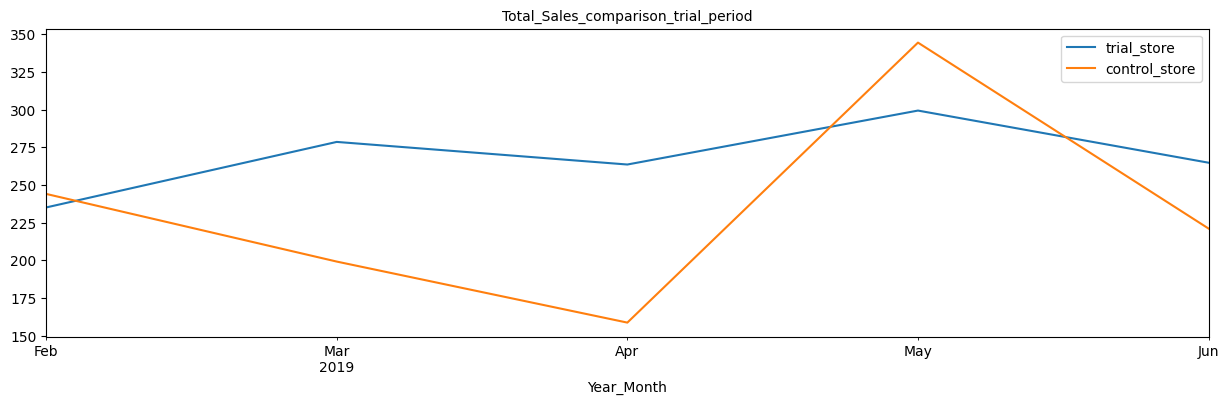

In [24]:
# Tot_sales

plt.figure(figsize=(15,4))
trial_stats_df.loc[77]['monthly_sales'].plot(label='trial_store')
trial_stats_df.loc[233]['monthly_sales'].plot(label='control_store')
plt.title('Total_Sales_comparison_trial_period',fontsize=10)
plt.legend()
plt.show()

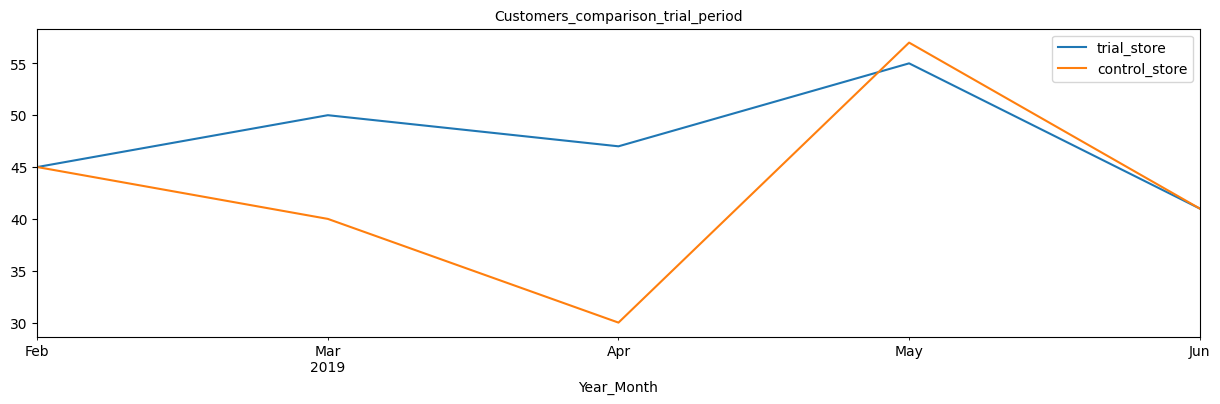

In [25]:
# Number of customers

plt.figure(figsize=(15,4))
trial_stats_df.loc[77]['monthly_uniq_cust'].plot(label='trial_store')
trial_stats_df.loc[233]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Customers_comparison_trial_period',fontsize=10)
plt.legend()
plt.show()

**STORE 86**

In [81]:
corr_df = calc_correlation(86)

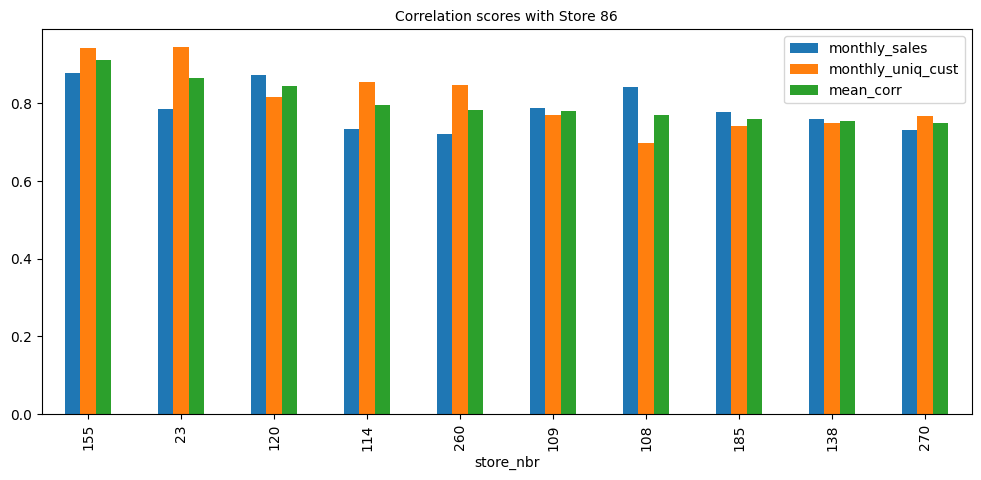

In [85]:
corr_df.head(10).plot(kind='bar',figsize=(12,5))
plt.title('Correlation scores with Store 86',fontsize=10)
plt.show()

**Based on correlation scores, the most appropriate control store for Store 86 appears to be Store 155.**

**Total sales**

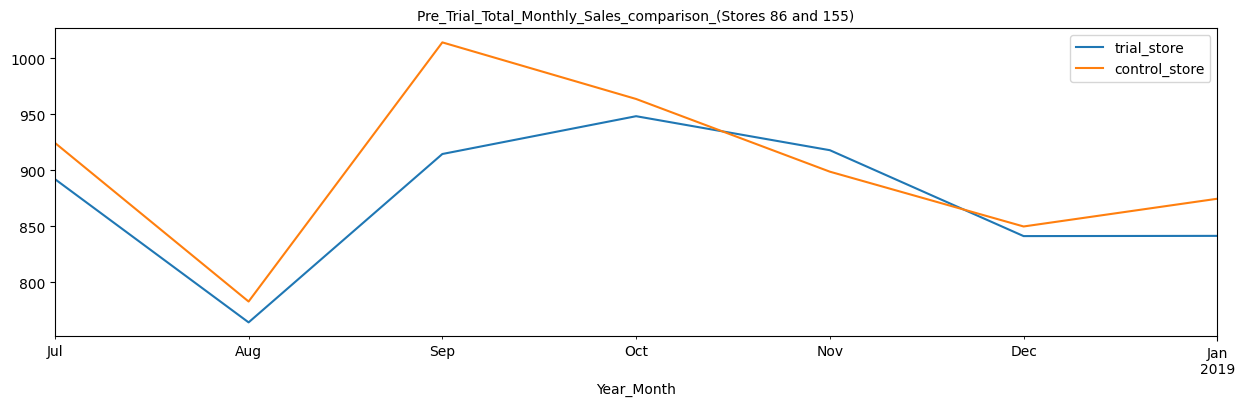

In [26]:
plt.figure(figsize=(15,4))
stats_df.loc[86]['monthly_sales'].plot(label='trial_store')
stats_df.loc[155]['monthly_sales'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_Sales_comparison_(Stores 86 and 155)',fontsize=10)
plt.legend()
plt.show()

**No. of customers**

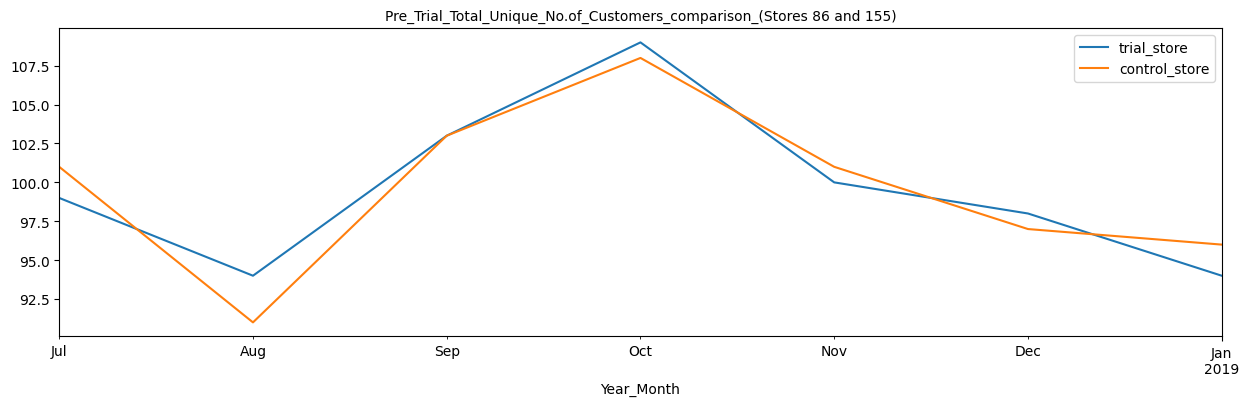

In [27]:
plt.figure(figsize=(15,4))
stats_df.loc[86]['monthly_uniq_cust'].plot(label='trial_store')
stats_df.loc[155]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Pre_Trial_Total_Unique_No.of_Customers_comparison_(Stores 86 and 155)',fontsize=10)
plt.legend()
plt.show()

**Conducting a null hypothesis to confirm the difference**

In [88]:
metrics = ['monthly_sales','monthly_uniq_cust']

In [56]:
values = []
ttest_res = []
for i in metrics:
  values.append(ks_2samp(stats_df.loc[86][i],stats_df.loc[155][i]))
  ttest_res.append(ttest_ind(stats_df.loc[86][i],stats_df.loc[155][i]))
diff_df = pd.DataFrame(values,index = metrics)
diff_df2 = pd.DataFrame(ttest_res,index = metrics)

In [57]:
# KS test results

values

[KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629, statistic_location=841.4, statistic_sign=1),
 KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629, statistic_location=100, statistic_sign=1)]

In [58]:
# T-test results

ttest_res

[Ttest_indResult(statistic=-0.7237694965753882, pvalue=0.4830786514047929),
 Ttest_indResult(statistic=0.0, pvalue=1.0)]

Results in all the tests show that there is not enough evidence to conclude that the two samples have different distributions.
This confirms the store 155 an ideal control store given their metric distributions are quite similar.

In [90]:
diff_df

,statistic,pvalue
monthly_sales,0.285714,0.962704
monthly_uniq_cust,0.285714,0.962704


In [91]:
diff_df2

,statistic,pvalue
monthly_sales,-0.723769,0.483079
monthly_uniq_cust,0.000000,1.000000


**Contrasting with trial period**

In [93]:
values = []
ttest_res = []
for i in metrics:
  values.append(ks_2samp(trial_stats_df.loc[86][i],trial_stats_df.loc[155][i]))
  ttest_res.append(ttest_ind(trial_stats_df.loc[86][i],trial_stats_df.loc[155][i]))
diff_df = pd.DataFrame(values,index = metrics)
diff_df2 = pd.DataFrame(ttest_res,index = metrics)

<ipython-input-93-d2c5ab9e7bcf>:4: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  values.append(ks_2samp(trial_stats_df.loc[86][i],trial_stats_df.loc[155][i]))


In [94]:
print(values)
print(ttest_res)

[KstestResult(statistic=0.2, pvalue=1.0, statistic_location=891.2, statistic_sign=-1), KstestResult(statistic=0.6, pvalue=0.35714285714285715, statistic_location=99, statistic_sign=-1)]
[Ttest_indResult(statistic=0.9914861460518972, pvalue=0.35048565098844203), Ttest_indResult(statistic=2.264554068289191, pvalue=0.05334189534187311)]


In [120]:
diff_df

,statistic,pvalue
monthly_sales,0.2,1.000000
monthly_uniq_cust,0.6,0.357143


In [121]:
diff_df2

,statistic,pvalue
monthly_sales,0.991486,0.350486
monthly_uniq_cust,2.264554,0.053342


The second t-test has a statistic of 2.264554068289191, a p-value of 0.05334189534187311. This means that the difference between the means of the two samples is 2.264554068289191, which is significant at a p-value of 0.05334189534187311. In other words, there is evidence to conclude that the mean of the first sample is significantly different from the mean of the second sample.

All other tests shows not enough evidence of any difference between the two statistics.

**Visualizing the trial period**

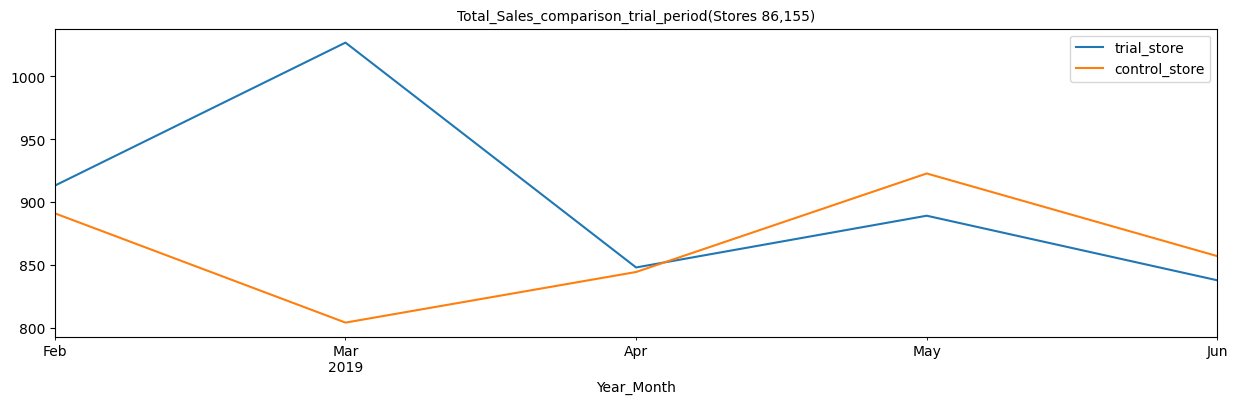

In [28]:
# Tot_sales

plt.figure(figsize=(15,4))
trial_stats_df.loc[86]['monthly_sales'].plot(label='trial_store')
trial_stats_df.loc[155]['monthly_sales'].plot(label='control_store')
plt.title('Total_Sales_comparison_trial_period(Stores 86,155)',fontsize=10)
plt.legend()
plt.show()

We notice a difference in sales during the month of March.

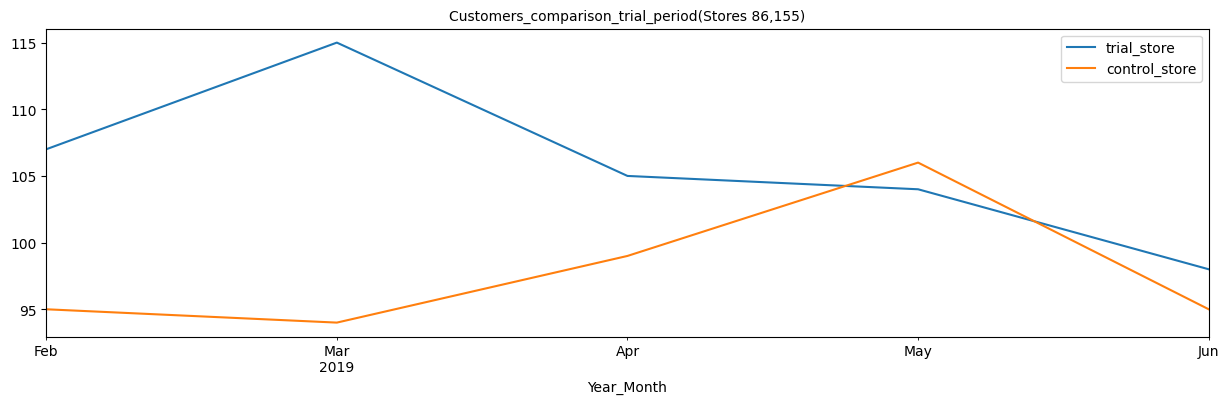

In [29]:
# Number of customers

plt.figure(figsize=(15,4))
trial_stats_df.loc[86]['monthly_uniq_cust'].plot(label='trial_store')
trial_stats_df.loc[155]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Customers_comparison_trial_period(Stores 86,155)',fontsize=10)
plt.legend()
plt.show()

Number of customers however seems to have increased in both March and April with the t_test results supporting this.

**STORE 88**

In [18]:
corr_df = calc_correlation(88)

Text(0.5, 1.0, 'Correlation scores with Store 88')

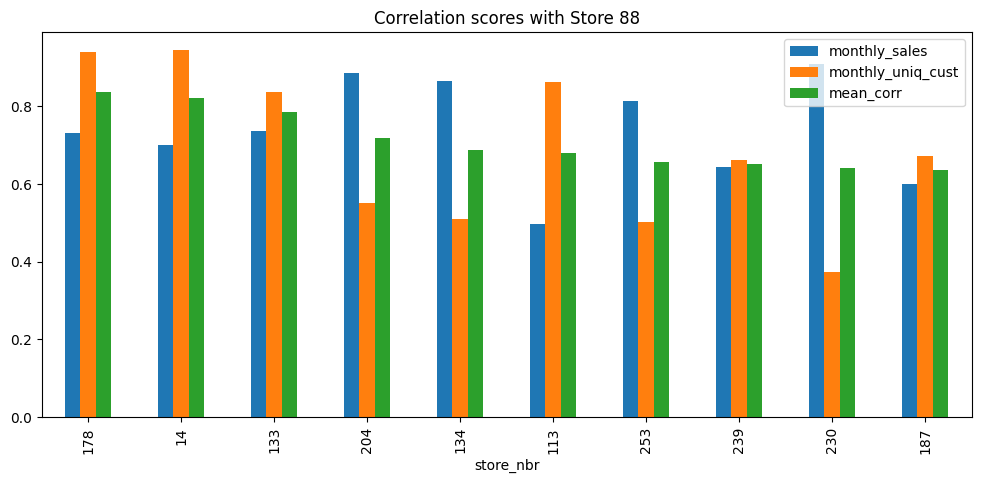

In [19]:
corr_df.head(10).plot(kind='bar',figsize=(12,5))
plt.title('Correlation scores with Store 88')

Let's visually contrast the performance metrics as well.

**Total sales**

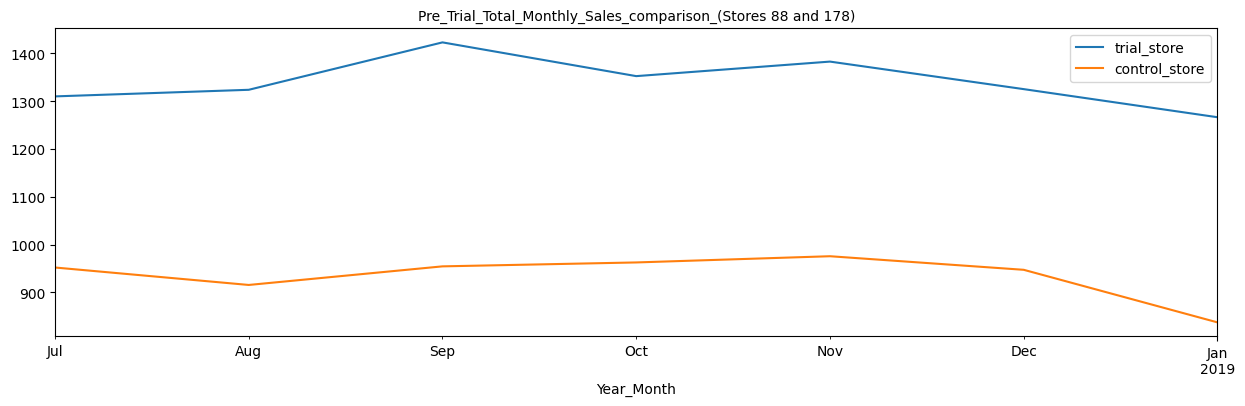

In [30]:
plt.figure(figsize=(15,4))
stats_df.loc[88]['monthly_sales'].plot(label='trial_store')
stats_df.loc[178]['monthly_sales'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_Sales_comparison_(Stores 88 and 178)',fontsize=10)
plt.legend()
plt.show()

**No. of customers**

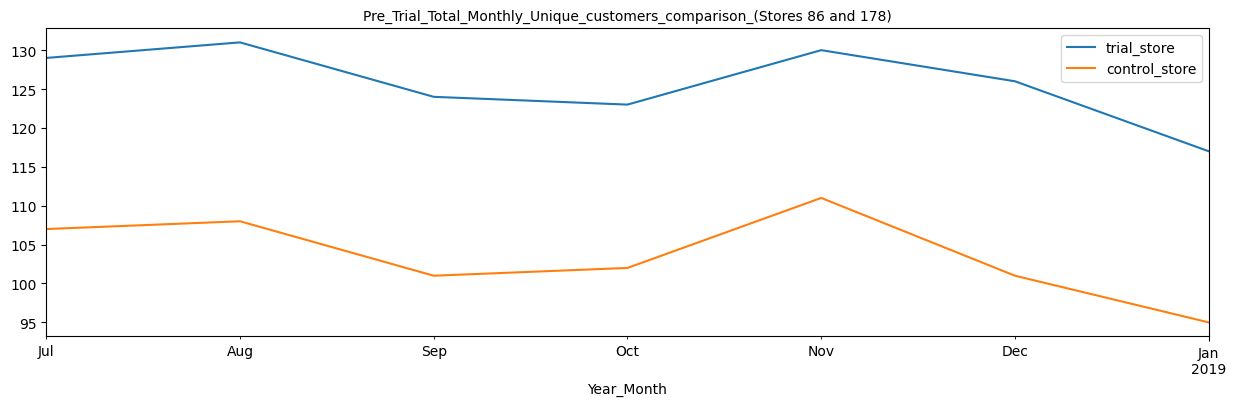

In [31]:
plt.figure(figsize=(15,4))
stats_df.loc[88]['monthly_uniq_cust'].plot(label='trial_store')
stats_df.loc[178]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_Unique_customers_comparison_(Stores 86 and 178)',fontsize=10)
plt.legend()
plt.show()

Despite both stores being the most correlated, there doesn't see to be much similarity in terms of both Sales and customers in terms of volume.
The trend however seems to be similar in both performance statistics.

Let's explore Store 14 as the scores were quite similar to 178

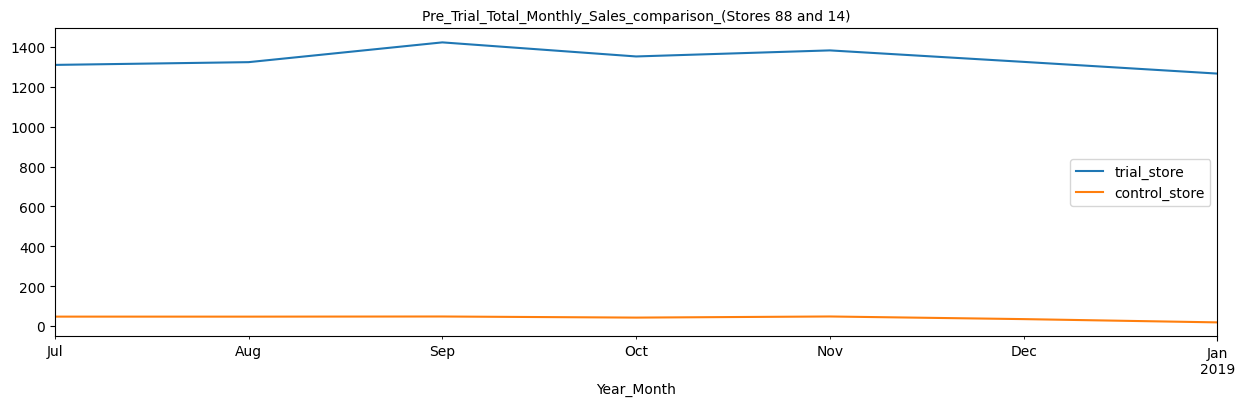

In [32]:
plt.figure(figsize=(15,4))
stats_df.loc[88]['monthly_sales'].plot(label='trial_store')
stats_df.loc[14]['monthly_sales'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_Sales_comparison_(Stores 88 and 14)',fontsize=10)
plt.legend()
plt.show()

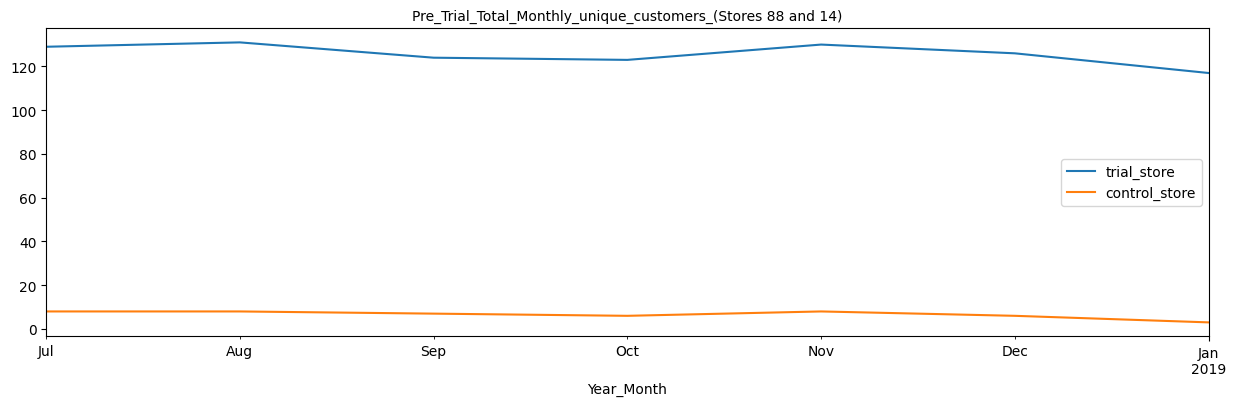

In [33]:
plt.figure(figsize=(15,4))
stats_df.loc[88]['monthly_uniq_cust'].plot(label='trial_store')
stats_df.loc[14]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_unique_customers_(Stores 88 and 14)',fontsize=10)
plt.legend()
plt.show()

Let's look at the correlations between the top two stores (178,14) to try and find a suitable control store.

In [30]:
calc_correlation(178).head()

,monthly_sales,monthly_uniq_cust,mean_corr
store_nbr,,,
14,0.833710,0.912632,0.873171
88,0.731857,0.939466,0.835661
237,0.657292,0.920018,0.788655
239,0.761122,0.767571,0.764347
134,0.792979,0.712301,0.752640


In [31]:
calc_correlation(14)

,monthly_sales,monthly_uniq_cust,mean_corr
store_nbr,,,
237,0.843427,9.133616e-01,0.878394
178,0.833710,9.126321e-01,0.873171
133,0.788360,8.746145e-01,0.831487
88,0.698557,9.429762e-01,0.820767
167,0.890764,7.495837e-01,0.820174
...,...,...,...
271,0.023843,2.940588e-02,0.026625
89,0.049379,1.651758e-03,0.025516
137,0.017951,1.406752e-02,0.016009


The other unique stores with a high correlation score appear to be 237 and 133.

Let's attempt to use a non_parametric way to solve for this.

In [38]:
metrics = ['monthly_sales','monthly_uniq_cust']

In [62]:
score_237 = []
score_133 = []
for i in metrics:
  score_237.append(ks_2samp(stats_df.loc[88][i],stats_df.loc[237][i]))
  score_133.append(ks_2samp(stats_df.loc[88][i],stats_df.loc[133][i]))

df_237 = pd.DataFrame(score_237,index = metrics)
df_133 = pd.DataFrame(score_133,index = metrics)

In [63]:
# KS results for stores 88,237

score_237

[KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629, statistic_location=1265.0, statistic_sign=-1),
 KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629, statistic_location=131, statistic_sign=1)]

In [64]:
# KS results for stores 88,133

score_133

[KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=1081.8, statistic_sign=-1),
 KstestResult(statistic=0.8571428571428571, pvalue=0.008158508158508158, statistic_location=120, statistic_sign=-1)]

The results of the KS tests suggest that there is evidence to conclude that the distributions of the two samples in the third and fourth output are different. However, there is not enough evidence to conclude that the distributions of the two samples in the first and second output are different.

Our ideal control store for store 88 is thus store 237 given we cannot statistically differentiate them through the period.

Visualizing the stores metrics (88,237)

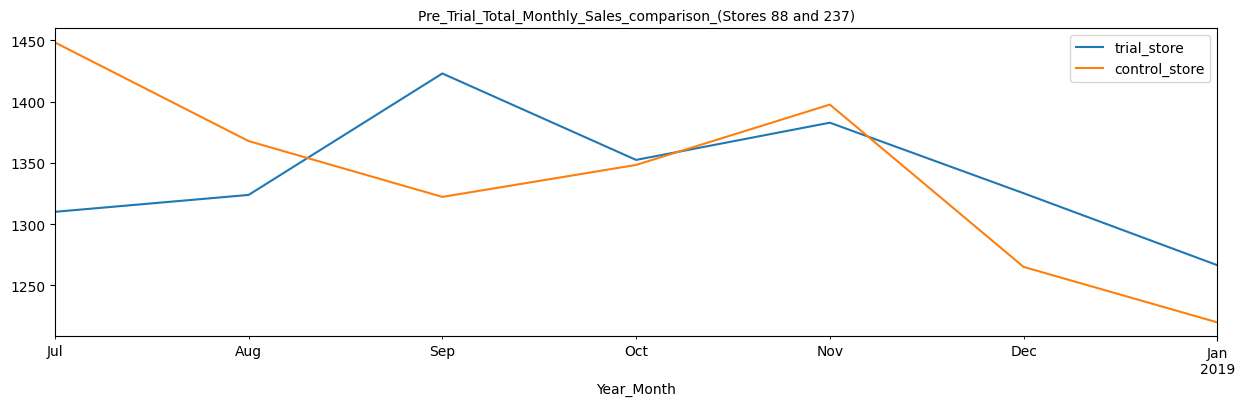

In [34]:
plt.figure(figsize=(15,4))
stats_df.loc[88]['monthly_sales'].plot(label='trial_store')
stats_df.loc[237]['monthly_sales'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_Sales_comparison_(Stores 88 and 237)',fontsize=10)
plt.legend()
plt.show()

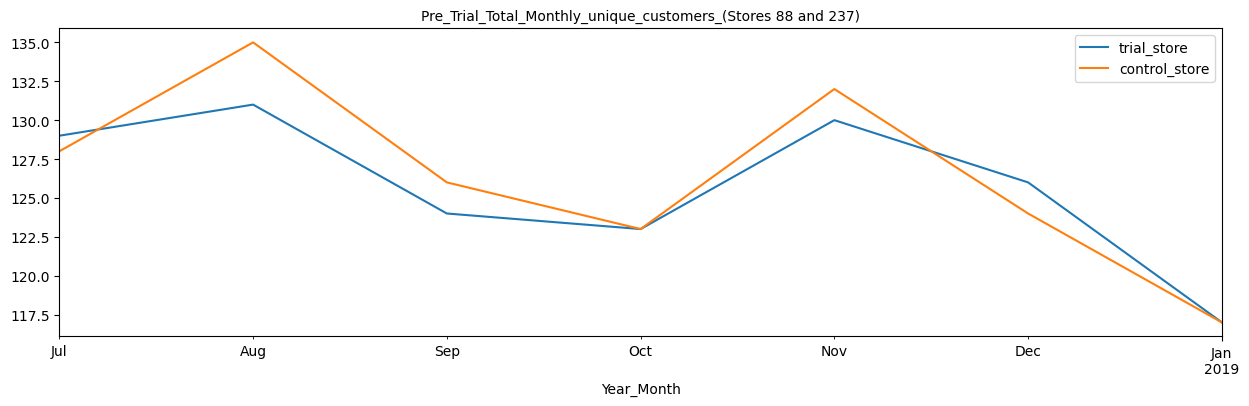

In [35]:
plt.figure(figsize=(15,4))
stats_df.loc[88]['monthly_uniq_cust'].plot(label='trial_store')
stats_df.loc[237]['monthly_uniq_cust'].plot(label='control_store')
plt.title('Pre_Trial_Total_Monthly_unique_customers_(Stores 88 and 237)',fontsize=10)
plt.legend()
plt.show()

**Hypothesis to confirm the difference**

Having already done a KS test before visualizing, we already confirmed that the stores distributions were quite similar.

In [42]:
ttest_res = []
for i in metrics:
  ttest_res.append(ttest_ind(stats_df.loc[88][i],stats_df.loc[237][i]))

diff_df2 = pd.DataFrame(ttest_res,index = metrics)

In [43]:
print(ttest_res)

[Ttest_indResult(statistic=0.059288459746211386, pvalue=0.9536982641840401), Ttest_indResult(statistic=-0.24494897427832063, pvalue=0.8106345632009028)]


In [44]:
diff_df2

,statistic,pvalue
monthly_sales,0.059288,0.953698
monthly_uniq_cust,-0.244949,0.810635


 T-tests results confirm the same that there is not enough evidence to conclude that the means of the two samples are significantly different.

**Contrasting with trial period**

In [49]:
values = []
ttest_res = []
for i in metrics:
  values.append(ks_2samp(trial_stats_df.loc[88][i],trial_stats_df.loc[237][i]))
  ttest_res.append(ttest_ind(trial_stats_df.loc[88][i],trial_stats_df.loc[237][i]))
diff_df = pd.DataFrame(values,index = metrics)
diff_df2 = pd.DataFrame(ttest_res,index = metrics)

In [52]:
# KS Results

values

[KstestResult(statistic=0.8, pvalue=0.07936507936507936, statistic_location=1208.2, statistic_sign=-1),
 KstestResult(statistic=0.6, pvalue=0.35714285714285715, statistic_location=120, statistic_sign=-1)]

In [53]:
# T-test results

ttest_res

[Ttest_indResult(statistic=2.9255589801196753, pvalue=0.01912775147213443),
 Ttest_indResult(statistic=1.4618020872072117, pvalue=0.18193462102321195)]

In [50]:
diff_df

,statistic,pvalue
monthly_sales,0.8,0.079365
monthly_uniq_cust,0.6,0.357143


In [51]:
diff_df2

,statistic,pvalue
monthly_sales,2.925559,0.019128
monthly_uniq_cust,1.461802,0.181935


KS tests suggest that there is not enough evidence to conclude that the distributions of the two samples are different.

Results of the first t-test shows enough evidence to conclude that the means of the two samples are significally different despite the second test not showing the same.

Additionaly, the p-value statistics appear to have gone down during the trial period despite showing no significant difference.

**Visualizing the trial period**

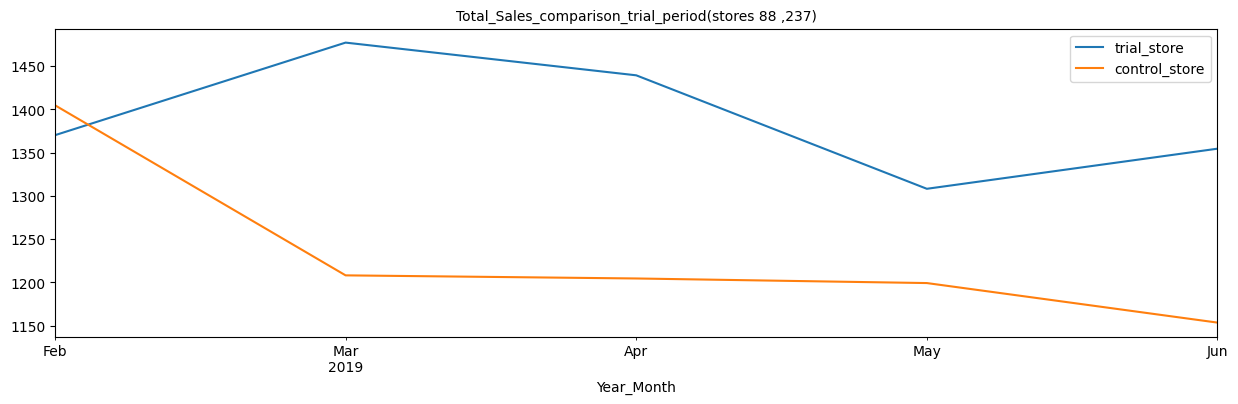

In [36]:
# Tot_sales

plt.figure(figsize=(15,4))
trial_stats_df.loc[88]['monthly_sales'].plot(label='trial_store')
trial_stats_df.loc[237]['monthly_sales'].plot(label='control_store')
plt.title('Total_Sales_comparison_trial_period(stores 88 ,237)',fontsize=10)
plt.legend()
plt.show()

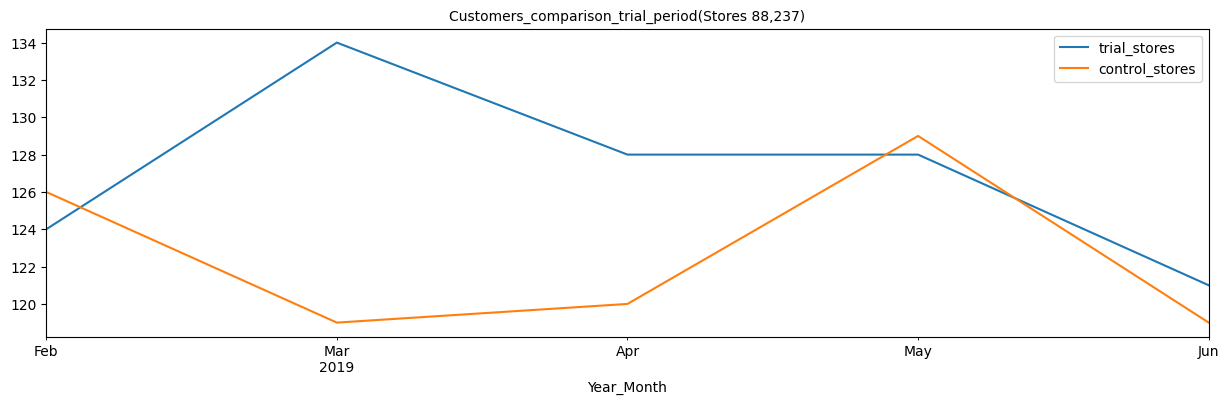

In [37]:
# Number of customers

plt.figure(figsize=(15,4))
trial_stats_df.loc[88]['monthly_uniq_cust'].plot(label='trial_stores')
trial_stats_df.loc[237]['monthly_uniq_cust'].plot(label='control_stores')
plt.title('Customers_comparison_trial_period(Stores 88,237)',fontsize=10)
plt.legend()
plt.show()

**Conclusion and Findings**

Stores 77 and 233

*   A difference was observed in the months of March and April in both Monthly sales and Number of customers, with the other months showing no change.
*   However, no statistical difference was observed during the trial period on both metrics.

Stores 86 and 155

*   A difference in Monthly_total_sales was observed only around March
*   Number of customers however showed a difference in the months of March and April unlike the total sales.
*   We also observed a significant difference in the Number of unique customers over the trial period supporting the visual finding.(T-test)
*   It could be worth looking into why the trial resulted in an increase in the number of customers but not in the sales made.

Stores 88 and 237


*   A difference was observed in Monthly sales in the months of March, April, May and June.
*   On the Number of Customers however, an increase was observed only in the months of March and April.
*   A significant difference was also observed in Monthly Sales supporting the visuals as well(T-test)
*   Despite not increasing the number of customers significantly, total monthly sales experienced a huge change. This could be worth looking into ie Potentially the trial targeted high quality customers.










